In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import random
import glob
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPool2D, Activation, Add, LeakyReLU, SpatialDropout2D, concatenate
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K

In [ ]:
SIZE_X = 256
SIZE_Y = 256
n_classes=7
num_images = 200

In [ ]:
image_names = glob.glob('dataset/data_for_training_and_testing/image/*.jpg')
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [
    cv2.cvtColor(cv2.imread(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    for image in image_names_subset
]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset

array([[[[[104,  86,  62]],

         [[101,  83,  59]],

         [[105,  87,  63]],

         ...,

         [[ 53,  65,  43]],

         [[ 56,  64,  43]],

         [[ 58,  66,  45]]],


        [[[109,  91,  67]],

         [[108,  90,  66]],

         [[110,  92,  68]],

         ...,

         [[ 66,  78,  56]],

         [[ 56,  65,  44]],

         [[ 69,  78,  57]]],


        [[[111,  95,  70]],

         [[109,  93,  68]],

         [[108,  90,  66]],

         ...,

         [[ 72,  87,  64]],

         [[ 58,  72,  49]],

         [[ 63,  75,  53]]],


        ...,


        [[[ 91,  85,  61]],

         [[ 90,  84,  60]],

         [[ 93,  89,  64]],

         ...,

         [[ 45,  66,  51]],

         [[ 45,  66,  51]],

         [[ 44,  65,  50]]],


        [[[ 94,  90,  65]],

         [[ 91,  87,  62]],

         [[ 90,  86,  61]],

         ...,

         [[ 44,  65,  50]],

         [[ 49,  70,  55]],

         [[ 45,  66,  51]]],


        [[[ 85,  81,  56]],

 

In [ ]:
mask_names = glob.glob('dataset/data_for_training_and_testing/mask/*.png')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset

array([[[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [225, 225, 225, ..., 105, 105, 105],
        [225, 225, 225, ..., 105, 105, 105],
        [225, 225, 225, ..., 105, 105, 105]],

       [[225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        [225, 225, 225, ..., 225, 225, 225],
        ...,
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105],
        [105, 105, 105, ..., 105, 105, 105]],

       [[225, 225, 225, ..., 105, 105, 105],
        [225, 225, 225, ..., 105, 105, 105],
        [225, 225, 225, ..., 105, 105, 105],
        ...,
        [ 29,  29,  29, ..., 105, 105, 105],
        [ 29,  29,  29, ..., 105, 105, 105],
        [ 29,  29,  29, ..., 105, 105, 105]],

       ...,

       [[105, 105, 105, ..., 149, 149, 149],
        [105, 105, 105, ..., 149, 149, 149],
        [105, 105, 105, ..., 149, 149, 149

In [54]:
print("Image data shape :", image_dataset.shape)
print("Mask data shape :", mask_dataset.shape)
print("Maximum pixel value in images :", image_dataset.max())
print("Labels in masks :", np.unique(mask_dataset))
print("Number of labels :", len(np.unique(mask_dataset)))

Image data shape : (200, 256, 256, 1, 3)
Mask data shape : (200, 256, 256)
Maximum pixel value in images : 255
Labels in masks : [  0  29 105 149 178 225 255]
Number of labels : 7


In [ ]:
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6])

In [56]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(200, 256, 256, 1)


In [ ]:
image_dataset = image_dataset / 255.
image_dataset

array([[[[[0.40784314, 0.3372549 , 0.24313725]],

         [[0.39607843, 0.3254902 , 0.23137255]],

         [[0.41176471, 0.34117647, 0.24705882]],

         ...,

         [[0.20784314, 0.25490196, 0.16862745]],

         [[0.21960784, 0.25098039, 0.16862745]],

         [[0.22745098, 0.25882353, 0.17647059]]],


        [[[0.42745098, 0.35686275, 0.2627451 ]],

         [[0.42352941, 0.35294118, 0.25882353]],

         [[0.43137255, 0.36078431, 0.26666667]],

         ...,

         [[0.25882353, 0.30588235, 0.21960784]],

         [[0.21960784, 0.25490196, 0.17254902]],

         [[0.27058824, 0.30588235, 0.22352941]]],


        [[[0.43529412, 0.37254902, 0.2745098 ]],

         [[0.42745098, 0.36470588, 0.26666667]],

         [[0.42352941, 0.35294118, 0.25882353]],

         ...,

         [[0.28235294, 0.34117647, 0.25098039]],

         [[0.22745098, 0.28235294, 0.19215686]],

         [[0.24705882, 0.29411765, 0.20784314]]],


        ...,


        [[[0.35686275, 0.33333333,

In [ ]:
image_dataset = image_dataset.reshape((image_dataset.shape[0], image_dataset.shape[1], image_dataset.shape[2], image_dataset.shape[4]))
print("Fixed image_dataset shape:", image_dataset.shape)

Fixed image_dataset shape: (200, 256, 256, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_train_cat.shape)

(160, 256, 256, 7)


In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = SpatialDropout2D(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(num_filters, 1, padding="same")(input)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.1)(x)

    return x

def encoder_block(input, num_filters, dropout_rate=0.3):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    p = Dropout(dropout_rate)(p)
    return x, p

def attention_block(x, g, num_filters):
    theta_x = Conv2D(num_filters, 1, padding="same")(x)
    phi_g = Conv2D(num_filters, 1, padding="same")(g)
    attn_map = Activation('relu')(Add()([theta_x, phi_g]))
    attn_map = Conv2D(1, 1, activation='sigmoid', padding="same")(attn_map)
    return x * attn_map

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 3, strides=(2, 2), padding="same")(input)
    skip_features = attention_block(skip_features, x, num_filters)

    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def bottleneck(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", dilation_rate=2)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(num_filters, 3, padding="same", dilation_rate=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = bottleneck(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net-Enhanced")
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 3)


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        ce_loss = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * ce_loss, axis=-1)
    return loss

def combined_loss(y_true, y_pred):
    loss_ce = CategoricalCrossentropy()(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    loss_focal = focal_loss()(y_true, y_pred)
    return 0.4 * loss_ce + 0.4 * loss_dice + 0.2 * loss_focal

In [ ]:
optimizer = AdamW(learning_rate=0.00001, weight_decay=1e-4)

model = build_unet(input_shape, n_classes=7)
model.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "U-Net-Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_386 (Conv2D)       │ (None, 256, 256, 64)   │          1,792 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_333   │ (None, 256, 256, 64)   │            256 │ conv2d_386[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_260           │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_82      │ (None, 256, 256, 64)   │              0 │ leaky_re_lu_260[0][0]  │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_387 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ spatial_dropout2d_82[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_334   │ (None, 256, 256, 64)   │            256 │ conv2d_387[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_261           │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_388 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ leaky_re_lu_261[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_389 (Conv2D)       │ (None, 256, 256, 64)   │            256 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_335   │ (None, 256, 256, 64)   │            256 │ conv2d_388[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_336   │ (None, 256, 256, 64)   │            256 │ conv2d_389[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_56 (Add)              │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_262           │ (None, 256, 256, 64)   │              0 │ add_56[0][0]           │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_70     

 Total params: 42,391,115 (161.71 MB)

 Trainable params: 42,371,659 (161.64 MB)

 Non-trainable params: 19,456 (76.00 KB)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)

X_train shape: (160, 256, 256, 3)
y_train_cat shape: (160, 256, 256, 7)


In [ ]:
print("X_train shape:", X_test.shape)
print("y_train_cat shape:", y_test_cat.shape)

X_train shape: (40, 256, 256, 3)
y_train_cat shape: (40, 256, 256, 7)


In [139]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 4,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    shuffle=True)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 593ms/step - accuracy: 0.2235 - loss: 1.2887 - val_accuracy: 0.2929 - val_loss: 1.1754
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 490ms/step - accuracy: 0.2606 - loss: 1.2022 - val_accuracy: 0.2933 - val_loss: 1.1513
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.2983 - loss: 1.1359 - val_accuracy: 0.2937 - val_loss: 1.1278
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 471ms/step - accuracy: 0.2985 - loss: 1.1242 - val_accuracy: 0.2939 - val_loss: 1.1174
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.3306 - loss: 1.0817 - val_accuracy: 0.2940 - val_loss: 1.1216
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 513ms/step - accuracy: 0.3339 - loss: 1.0684 - val_accuracy: 0.2940 - val_loss: 1.1236
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 516ms/step - accuracy: 0.3270 - loss: 1.0577 - val_accuracy: 0.2939 - val_loss: 1.1431
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.3424 - loss: 1.0330 - 

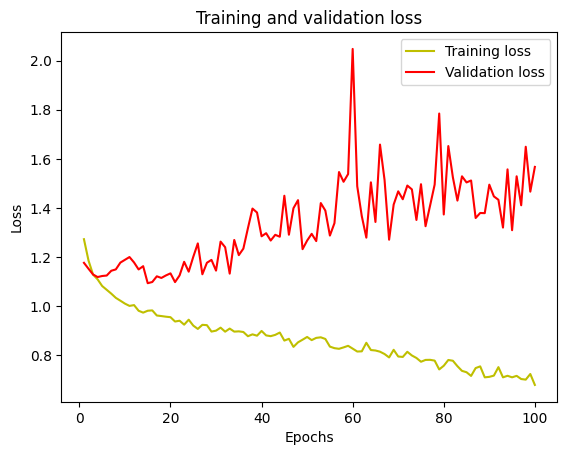

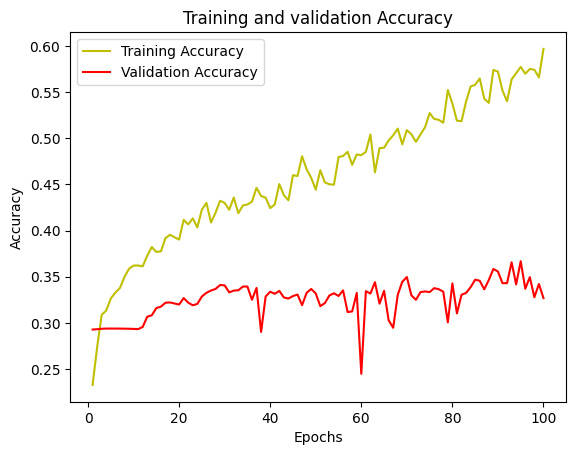

In [140]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [141]:
y_pred=model.predict(X_test)
y_pred.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step


(40, 256, 256, 7)

In [123]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(40, 256, 256)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


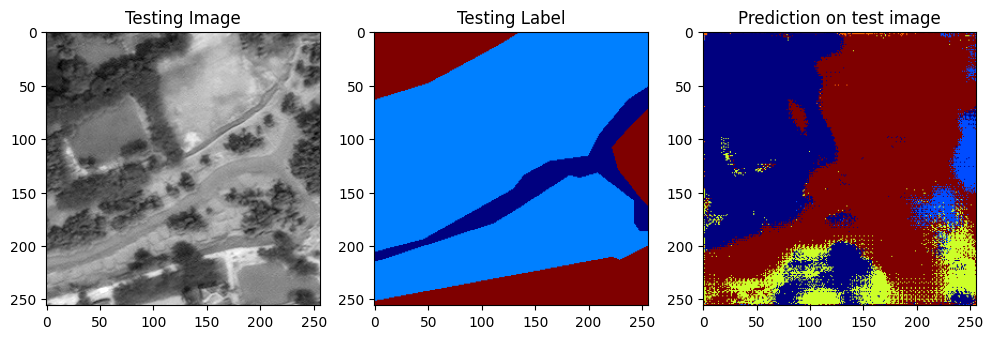

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


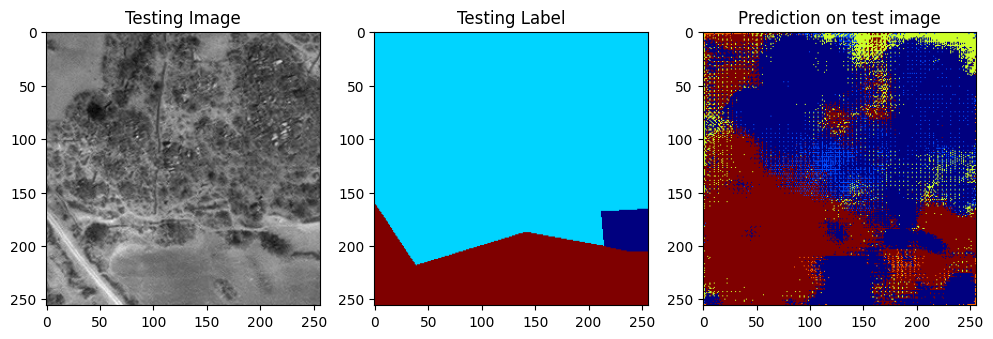

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


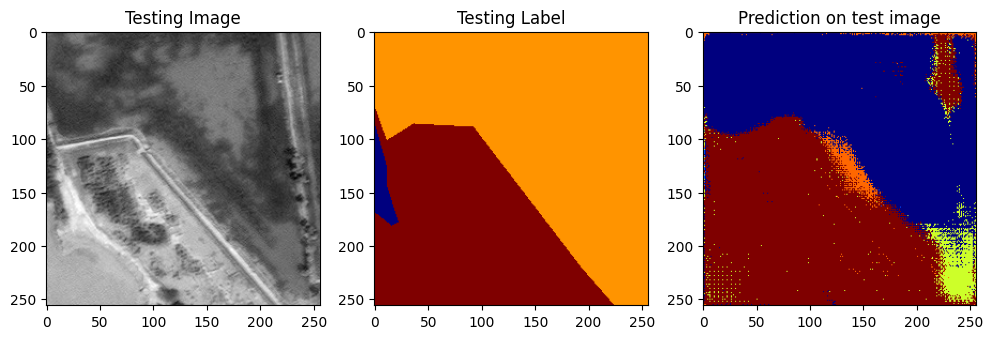

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


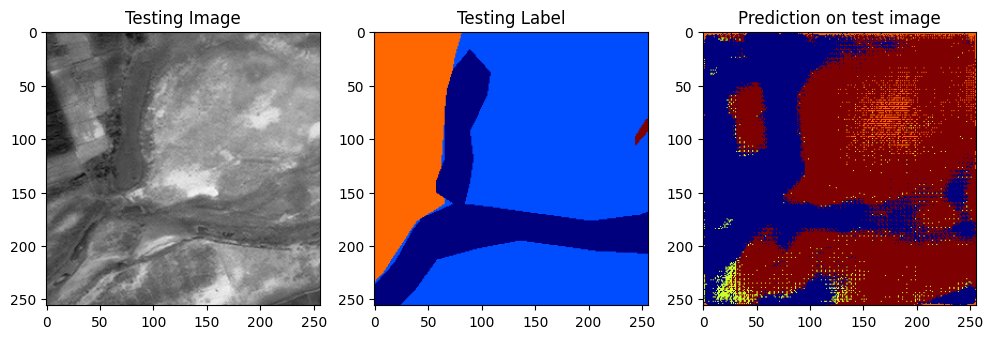

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


In [ ]:
for i in range (10):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm = np.repeat(test_img[:, :, 0][:, :, None], 3, axis=-1)
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]


    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()